In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 

import numpy as np
from psana import *
import psana, time

In [2]:
class Detector:
    
    """
    Detector object useful for reshaping data from XTC into detector shape. Stripped
    down version of Detector class from pysingfel when that library isn't available.
    """
    
    def __init__(self, geom_file):
        """
        Initialize instance of Detector class.
        
        :param geom_file: path to *-end.data geometry file
        """
        
        from PSCalib.GeometryAccess import GeometryAccess
        self._geometry = GeometryAccess(geom_file, 0)
        self._compute_pixel_index_map()
        
    def _compute_pixel_index_map(self):
        """
        Compute various parameters related to detector dimensions and pixel indices
        and store as class variables.
        """
        
        # Set coordinate in real space (convert to m)
        temp = [np.asarray(t) * 1e-6 for t in self._geometry.get_pixel_coords()]
        temp_index = [np.asarray(t) for t in self._geometry.get_pixel_coord_indexes()]
        self._panel_num = np.prod(temp[0].shape[:-2])
        self._shape = (self._panel_num, temp[0].shape[-2], temp[0].shape[-1])
        
        pixel_index_map = np.zeros(self._shape + (2,))
        for n in range(2):
            pixel_index_map[..., n] = temp_index[n].reshape(self._shape)
        self._pixel_index_map = pixel_index_map.astype(np.int64)

        self._detector_pixel_num_x = int(np.max(self._pixel_index_map[..., 0]) + 1)
        self._detector_pixel_num_y = int(np.max(self._pixel_index_map[..., 1]) + 1)
        
        self._panel_index = np.zeros((self._detector_pixel_num_x, self._detector_pixel_num_y))
        for l in range(self._panel_num):
            self._panel_index[self._pixel_index_map[l, :, :, 0],
                              self._pixel_index_map[l, :, :, 1]] = l+1
        
        return        
        
    def assemble_image_stack(self, data):
        """
        Reassemble data retrieved from XTC file into shape of detector.
        
        :param data: list of stacked data from each quad of panels
        :return image: data in shape of detector
        """
        data = np.array(data).reshape(self._shape)
        image = np.zeros((self._detector_pixel_num_x, self._detector_pixel_num_y)).astype(np.int64)
        
        for l in range(self._panel_num):
            image[self._pixel_index_map[l, :, :, 0],
                  self._pixel_index_map[l, :, :, 1]] = data[l, :, :]
            
        return image


In [3]:
def retrieve_cspad_data(evt):
    """
    Retrieve intensities collected on CsPad from input event.
    
    :param evt: psana event object
    :return data: list of quads that make up measured data
    """
    data = list()
    cspad = evt.get(psana.CsPad.DataV2, psana.Source('DscCsPad'))
    for num in range(cspad.quads_shape()[0]):
        data.append(cspad.quads(num).data())
    
    return data

In [7]:
pnum = 25
pedestal_file = "/cds/data/psdm/cxi/cxi04915/calib/CsPad::CalibV1/CxiDs2.0:Cspad.0/pedestals/%i-end.data" %pnum
geom_file = "/cds/data/psdm/cxi/cxi04915/calib/CsPad::CalibV1/CxiDs2.0:Cspad.0/geometry/0-end.data"
det = Detector(geom_file)

In [11]:
start_time = time.time()

# retrieve several shots from dark and sample runs
dark, light = dict(), dict()
dark_idx, light_idx = 35, 36
total_evts = 10

for idx,d in zip([dark_idx, light_idx], [dark, light]):
    ds = psana.DataSource('exp=cxic0415:run=%i:smd' %idx)
    for num,evt in enumerate(ds.events()):
        if num == total_evts:
            break
        else:
            data = retrieve_cspad_data(evt)
            d[num] = det.assemble_image_stack(data)

# grab associated pedestal
pedestal = det.assemble_image_stack(np.loadtxt(pedestal_file))
            
print("elapsed time is %.2f min" %((time.time() - start_time)/60.0))

elapsed time is 0.07 min


Text(0,0.5,'Sample run')

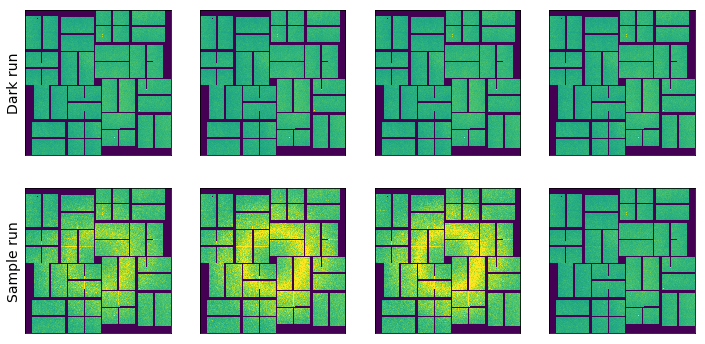

In [12]:
f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2, 4, figsize=(12,6))

for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.imshow(dark[i+3], vmax=2*np.mean(dark[0]))
    ax.set_xticks([])
    ax.set_yticks([])

for i,ax in enumerate([ax5,ax6,ax7,ax8]):
    ax.imshow(light[i+3], vmax=2*np.mean(dark[0]))
    ax.set_xticks([])
    ax.set_yticks([])

ax1.set_ylabel("Dark run", fontsize=14)
ax5.set_ylabel("Sample run", fontsize=14)